<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrumental Variables

The example and data is taken from [Non Compliance and LATE](https://matheusfacure.github.io/python-causality-handbook/09-Non-Compliance-and-LATE.html). Consider a scenario where you aim to increase user engagement by boosting in-app purchases. Your marketing team designs a fancy push notification campaign, and you conduct an experiment where 10,000 customers are randomly assigned to either receive the push or not. However, you find that some customers assigned to receive the push don't actually get it due to technical issues, such as having older phones that don't support the notification.

In [1]:
!pip install pyfixest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.5
    Uninstalling tqdm-4.66.5:
      Successfully uninstalled tqdm-4.66.5


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pyfixest as pf

%config InlineBackend.figure_format = "retina"

## Context

At first, it seems like you could simply analyze the impact by focusing on those who actually received the push. However, this introduces bias because users with older phones are less likely to receive the notification, which may be correlated with their income and affect in-app purchases.

Since income is an unobserved variable, using treatment received leads to selection bias (confounding). Similarly, using treatment assigned doesn’t capture the true effect because non-compliance dilutes the treatment impact. To address this, instrumental variables come into play.

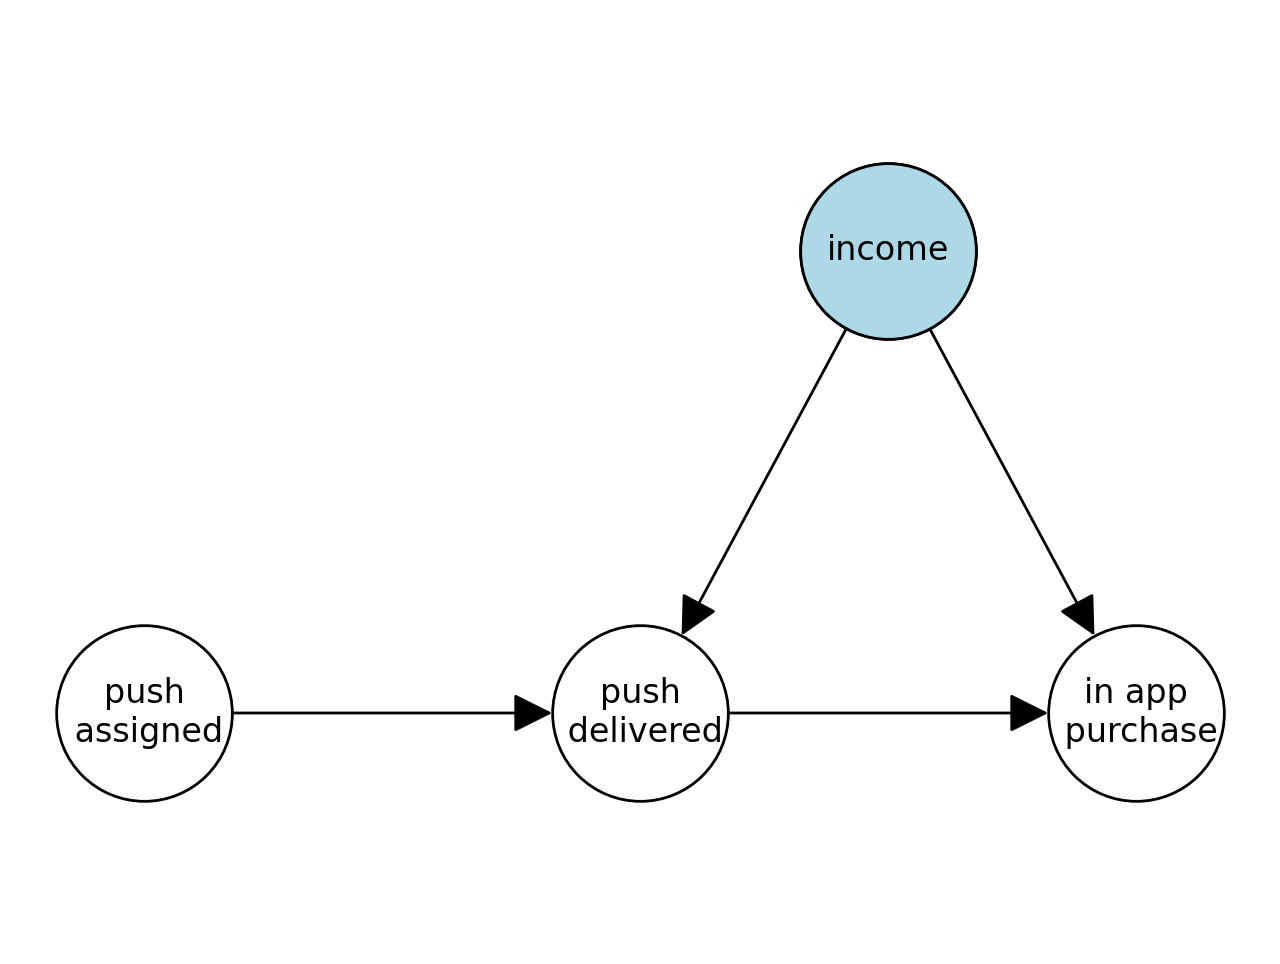

In [3]:
# Create a directed graph
G = nx.DiGraph()

# Add edges (nodes are created automatically)
G.add_edges_from([
    ("push\n assigned", "push\n delivered"),
    ("push\n delivered", "in app\n purchase"),
    ("income", "push\n delivered"),
    ("income", "in app\n purchase")
])

# Define node positions for a more visually appealing layout
pos = {
    "push\n assigned": (0, 0),
    "push\n delivered": (1, 0),
    "income": (1.5, 0.5),
    "in app\n purchase": (2, 0)
}

# Draw the nodes and edges
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='white', edgecolors='black', node_shape='o')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowsize=30, node_size=4000)

# Draw labels for the nodes
nx.draw_networkx_labels(G, pos, font_size=12)

# Highlight the 'income' node in blue
nx.draw_networkx_nodes(G, pos, nodelist=["income"], node_size=4000, node_color='lightblue', edgecolors='black')

# Disable axis and limits
plt.axis('off')
plt.xlim(-0.25, 2.25)
plt.ylim(-0.25, 0.75)

# Show the plot
plt.show()

#DAG: Direct Acrylic Graphs:

In [4]:
# Read data
path_data = "https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/"
data = pd.read_csv(path_data + 'app_engagement_push.csv')
data['in_app_purchase'] = (data['in_app_purchase'] / 10).round(0).astype(int)  # transform to USD
data.tail()

,in_app_purchase,push_assigned,push_delivered
9995,5,0,0
9996,7,1,1
9997,4,0,0
9998,6,0,0
9999,7,0,0


In [5]:
data.describe().round(2)

,in_app_purchase,push_assigned,push_delivered
count,10000.00,10000.00,10000.00
mean,7.04,0.49,0.35
std,2.63,0.50,0.48
min,1.00,0.00,0.00
25%,5.00,0.00,0.00
50%,7.00,0.00,0.00
75%,9.00,1.00,1.00
max,22.00,1.00,1.00


## OLS

In [12]:
# Run OLS of in_app_purchase on push_assigned and push_delivered
ols = pf.feols('in_app_purchase ~ push_assigned + push_delivered', data=data) #fixed effects OLS, even if we don't have fixed effects here.
ols.summary()

###

Estimation:  OLS
Dep. var.: in_app_purchase, Fixed effects: 0
Inference:  iid
Observations:  10000

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      6.925 |        0.035 |   199.124 |      0.000 |  6.857 |   6.993 |
| push_assigned  |     -1.741 |        0.075 |   -23.284 |      0.000 | -1.888 |  -1.594 |
| push_delivered |      2.763 |        0.078 |    35.362 |      0.000 |  2.610 |   2.916 |
---
RMSE: 2.473 R2: 0.113 


OLS estimates that the push notification increases in-app purchases by \$2. However, this estimate is likely biased. Since older phones struggle to receive the push, wealthier customers with newer phones are more likely to comply. As a result, the estimate might be positively biased, meaning the true effect of the push is likely lower than \$2.

## Two-Stage Least Squares (2SLS)

In [13]:
# Run TSLS of in_app_purchase on push_delivered using push_assigned as an instrument
iv = pf.feols(fml='in_app_purchase ~ 1 | push_delivered ~ push_assigned', data=data)
iv.summary()

###

Estimation:  IV
Dep. var.: in_app_purchase, Fixed effects: 0
Inference:  iid
Observations:  10000

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      6.925 |        0.036 |   190.175 |      0.000 |  6.854 |   6.996 |
| push_delivered |      0.337 |        0.072 |     4.669 |      0.000 |  0.196 |   0.479 |
---



The 2SLS estimate is much lower than the OLS result, showing 30 cents compared to $2. This is expected, as the OLS estimate was likely biased upward.

In [14]:
pf.etable([iv._model_1st_stage, iv])

GT(_tbl_data=  level_0         level_1                      0                      1
0    coef   push_assigned  0.718*** <br> (0.006)                       
1    coef  push_delivered                         0.337*** <br> (0.072)
2    coef       Intercept     0.000 <br> (0.004)  6.925*** <br> (0.036)
3   stats    Observations                  10000                  10000
4   stats       S.E. type                    iid                    iid
5   stats   R<sup>2</sup>                  0.562                      -, _body=<great_tables._gt_data.Body object at 0x7e95b1db5c90>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7e95a752d990>, _spanners=Spanners([SpannerInfo(spanner_id='push_delivered', spanner_level=1, spanner_label='push_delivered', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='in_app_purchase', spanner_level=1, spanner_label='in_app_purchase', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7e95b8bef6a0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=True, categor



Importantly, the 2SLS result represents the Local Average Treatment Effect (LATE), which captures the average causal effect on compliers—those with newer phones. Unfortunately, we cannot infer the effect on "never takers," or those with older phones, meaning the estimate mainly reflects the impact on the wealthier portion of the population.

In [15]:
print('Traditional First Stage F-statistic: {:.2f}'.format(iv._f_stat_1st_stage))
iv.IV_Diag()
print('Robust First Stage F-statistic: {:.2f}'.format(iv._eff_F))

Traditional First Stage F-statistic: 12846.41
Robust First Stage F-statistic: 12556.82


The F-Statistic of the first stage indicates the strength of the instrument. A rule of thumb is that an F-statistic below 10 suggests a weak instrument, which can lead to biased estimates. In this case, the F-statistic is above 10, indicating a strong instrument.

The robust F-Statisitic is also calculated to allow for errors that are not conditionally homoskedastic and serially uncorrelated.

https://blogs.worldbank.org/en/impactevaluations/weekly-links-october-4--2024--why-optimal-taxes-may-look-differe?CID=WBW_AL_BlogNotification_EN_EXT

## Weak IV

In [2]:
rng = np.random.default_rng(42)

n = 100
beta = 0.1  # 0.1 weak IV
# beta = 1  # 1 strong IV

# Simulate data
U = rng.normal(size=n)  # generate error term
Z = rng.normal(size=n)  # generate instrument
D = beta * Z + U        # generate endogenous variable
Y = D + U               # the true causal effect is 1

df = pd.DataFrame({'Y': Y, 'D': D, 'Z': Z})
df.sample(5)

,Y,D,Z
59,1.818062,0.849784,-1.184944
48,1.464425,0.785512,1.065980
61,-0.742293,-0.407408,-0.725226
58,-1.781592,-0.915761,-0.499296
21,-1.343932,-0.663002,0.179276


In [3]:
# Run TSLS of Y on D using Z as instrument
iv = pf.feols(fml='Y ~ 1 | D ~ Z', data=df)
#iv.summary()
pf.etable([iv._model_1st_stage, iv])

GT(_tbl_data=  level_0        level_1                    0                      1
0    coef              Z  0.175* <br> (0.080)                       
1    coef              D                       1.428*** <br> (0.261)
2    coef      Intercept  -0.049 <br> (0.078)    -0.028 <br> (0.046)
3   stats   Observations                  100                    100
4   stats      S.E. type                  iid                    iid
5   stats  R<sup>2</sup>                0.047                      -, _body=<great_tables._gt_data.Body object at 0x7f1d1c5e63b0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f1d1c5e4bb0>, _spanners=Spanners([SpannerInfo(spanner_id='D', spanner_level=1, spanner_label='D', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f1d1c5e5300>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(s

Note that the instrument is weak here (strength of the instrument is controlled by setting $\beta$) -- the t-stat is smaller than any rule-of-thumb suggested in the literature (e.g. $\sqrt{10}$) .

In [4]:
# Print First Stage F-statistic
print('Traditional First Stage F-statistic: {:.2f}'.format(iv._f_stat_1st_stage))
#it's lower than 10, meaning it's a weak instrument

Traditional First Stage F-statistic: 4.81


In [ ]:
# Run 10000 trials to evaluate distribution of the IV estimator

nsim = 1000  # trials
ivsims = np.zeros(nsim)

for i in range(nsim):
    # Simulate data
    U = rng.normal(size=n)  # generate error term
    Z = rng.normal(size=n)  # generate instrument
    D = beta * Z + U        # generate endogenous
    Y = D + U               # the true causal effect is
    df = pd.DataFrame({'Y': Y, 'D': D, 'Z': Z})

   #estimate IV
    # Run TSLS of Y on D using Z as instrument
    iv = pf.feols(fml='Y ~ 1 | D ~ Z', data=df)

        #Obtain coefficient and save it in ivsims
ivsims[i] = iv.coef()['D']

    # Print First Stage F-statistic
print('Traditional First Stage F-statistic: {:.2f}'.format(iv._f_stat_1st_stage))
    #print('Robust First Stage F-statistic: {:.2f}'.format(iv._eff_F))



Exception ignored in: <function _xla_gc_callback at 0x7f1d307949d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f1d307949d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f1d307949d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f1d307949d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_

In [ ]:
# Plot the Actual Distribution against the Normal Approximation (based on Strong Instrument Assumption)

import scipy.stats as stats

# Plotting the density of ivsims
plt.figure(figsize=(8, 6))
plt.xlim(-5, 5)
plt.xlabel("IV Estimator - True Effect")
plt.title("Actual Distribution vs Gaussian")

# Plotting density estimate of simulated IV coefficients
val = np.linspace(-5, 5, 200)
kde = stats.gaussian_kde(ivsims - 1, bw_method=.001)  # Need to play with bandwidth depending on problem features.
density = kde(np.linspace(-5, 5, 1000))
plt.plot(np.linspace(-5, 5, 1000), density, color='blue', label='Actual Distribution')

# Plotting Gaussian distribution
var = (1 / (beta ** 2)) * (1 / n)  # theoretical variance of IV
sd = np.sqrt(var)
gaussian = stats.norm.pdf(val, scale=sd)
plt.plot(val, gaussian, color='red', linestyle='--', label='Gaussian Distribution')

plt.legend()

# Calculating rejection frequency
rejection_frequency = np.sum(np.abs(ivsims - 1) / sd > 1.96) / nsim
print("Rejection Frequency is", rejection_frequency, "while we expect it to be around 0.05")

plt.show()